## Deep Learning Project 1 

Comparing digits

### TODO Next : 

- Add dropout layer and stuff like this **DONE**
- Add Auxilary losses (also return CNNs results and use them with a loss function, similar to comparisson net) **Done**
- Benchmark **Done** 
- Write report **Done** 

In [1]:
import torch
import math
import dlc_practical_prologue as prologue
from torch import optim
from torch import Tensor
from torch import nn
from torch.nn import functional as F

In [2]:
# Generate the train and test sets.
N = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

In [3]:
# This model performs each digit classification with 2 different CNNs (so no weight sharing)        
class Base_Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Layers that handle digit classification with first CNN
        self.conv1_1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1_1 = nn.Linear(256, 200)
        self.fc2_1 = nn.Linear(200, 10)
        
        # Layers that handle digit classification with second CNN
        self.conv1_2 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2_2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1_2 = nn.Linear(256, 200)
        self.fc2_2 = nn.Linear(200, 10)
        
        # Layers that handle comparisson 
        self.fc3 = nn.Linear(20, 300)
        self.fc4 = nn.Linear(300, 300)
        self.fc5 = nn.Linear(300, 2)
        
    def cnn1(self, x):
        x = F.relu(F.max_pool2d(self.conv1_1(x), kernel_size=2))
        x = F.relu(F.max_pool2d(self.conv2_1(x), kernel_size=2))
        x = F.relu(self.fc1_1(x.view(-1, 256)))
        x = self.fc2_1(x)
        return x
    
    def cnn2(self, x):
        x = F.relu(F.max_pool2d(self.conv1_2(x), kernel_size=2))
        x = F.relu(F.max_pool2d(self.conv2_2(x), kernel_size=2))
        x = F.relu(self.fc1_2(x.view(-1, 256)))
        x = self.fc2_2(x)
        return x
    
    def mlp(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
    def forward(self, x):
        s = x.shape
        input_1 = x[:,0,:,:].reshape([s[0],1,s[2],s[3]])
        input_2 = x[:,1,:,:].reshape([s[0],1,s[2],s[3]])
        
        output_1 = self.cnn1(input_1)
        output_2 = self.cnn2(input_2)
        
        concatenated = torch.cat((output_1, output_2), 1)
        
        comparison = self.mlp(concatenated)
        return comparison   

In [4]:
# Weight Sharing model definition 
class Weight_Sharing_Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Layers that handle digit classification 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)
        
        # Layers that handle comparisson 
        self.fc3 = nn.Linear(20, 300)
        self.fc4 = nn.Linear(300, 300)
        self.fc5 = nn.Linear(300, 2)
        
    def cnn(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x
    
    def mlp(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
    def forward(self, x):
        s = x.shape
        input_1 = x[:,0,:,:].reshape([s[0],1,s[2],s[3]])
        input_2 = x[:,1,:,:].reshape([s[0],1,s[2],s[3]])
        
        output_1 = self.cnn(input_1)
        output_2 = self.cnn(input_2)
        
        concatenated = torch.cat((output_1, output_2), 1)
        
        comparison = self.mlp(concatenated)
        return comparison   

In [5]:
def train_model_base_ws(model, train_input, train_target, mini_batch_size, nb_epochs = 100, use_optimizer= None, _print=False):
    criterion = nn.CrossEntropyLoss()
    eta = 1e-3
    if use_optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=eta)
    if use_optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=eta)
    for e in range(nb_epochs):
        acc_loss = 0

        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            target = train_target.narrow(0, b, mini_batch_size).long()
            loss = criterion(output, target)
            acc_loss = acc_loss + loss.item()
 
            model.zero_grad()
            loss.backward()
            
            if use_optimizer != None :
                optimizer.step()
            else :
                with torch.no_grad():
                    for p in model.parameters():
                        p -= eta * p.grad
        if _print:
            print(e, acc_loss)
        
def compute_nb_errors_base_ws(model, input, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if target[b + k, predicted_classes[k]] <= 0:
                nb_errors = nb_errors + 1

    return nb_errors

In [6]:
model_total = Base_Net()

train_model_base_ws(model_total, train_input, train_target, mini_batch_size=250, nb_epochs=25, use_optimizer="adam")

test_target_total = prologue.convert_to_one_hot_labels(test_input, test_target)
nb_test_errors = compute_nb_errors_base_ws(model_total, test_input, test_target_total, mini_batch_size=250)
print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))

test error Net 17.00% 170/1000


In [7]:
model_total = Weight_Sharing_Net()

train_model_base_ws(model_total, train_input, train_target, mini_batch_size=250, nb_epochs=25, use_optimizer="adam")

test_target_total = prologue.convert_to_one_hot_labels(test_input, test_target)
nb_test_errors = compute_nb_errors_base_ws(model_total, test_input, test_target_total, mini_batch_size=250)
print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))

test error Net 16.00% 160/1000


In [8]:
# Model using WS + Auxiliary Loss 
class Auxiliary_Loss_Weight_Sharing_Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Layers that handle digit classification 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)
        
        # Layers that handle comparisson 
        self.fc3 = nn.Linear(20, 300)
        self.fc4 = nn.Linear(300, 300)
        self.fc5 = nn.Linear(300, 2)
        
    def cnn(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x
    
    def mlp(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
    def forward(self, x):
        s = x.shape
        
        input_1 = x[:,0,:,:].reshape([s[0],1,s[2],s[3]])
        input_2 = x[:,1,:,:].reshape([s[0],1,s[2],s[3]])
        
        output_1 = self.cnn(input_1)
        output_2 = self.cnn(input_2)
        
        concatenated = torch.cat((output_1, output_2), 1)
        
        comparison = self.mlp(concatenated)
        return output_1, output_2, comparison  

        
def train_model_auxiliary_loss(model, train_input, train_target, train_classes, mini_batch_size, nb_epochs = 100, use_optimizer= None, _print=False):
    criterion_auxilary = nn.CrossEntropyLoss()
    criterion_final = nn.CrossEntropyLoss()
    
    eta = 1e-3
    if use_optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=eta)
    if use_optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=eta)
    for e in range(nb_epochs):
        acc_loss = 0

        for b in range(0, train_input.size(0), mini_batch_size):
            digit_1, digit_2, comparison = model(train_input.narrow(0, b, mini_batch_size))
            
            target_comparison = train_target.narrow(0, b, mini_batch_size).long()
            
            target_digit_1, target_digit_2 = train_classes.narrow(0, b, mini_batch_size)[:,0], train_classes.narrow(0, b, mini_batch_size)[:,1]
            loss1 = criterion_auxilary(digit_1, target_digit_1)
            loss2 = criterion_auxilary(digit_2, target_digit_2)
            loss3 = criterion_final(comparison, target_comparison)
            acc_loss = acc_loss + loss1.item() + loss2.item() + loss3.item()
 
            model.zero_grad()
            loss1.backward(retain_graph=True)
            loss2.backward(retain_graph=True)
            loss3.backward()
            
            if use_optimizer != None :
                optimizer.step()
            else :
                with torch.no_grad():
                    for p in model.parameters():
                        p -= eta * p.grad
        if _print :
            print(e, acc_loss)
            
def compute_nb_errors_auxilary_loss(model, input, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        _, _, output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if target[b + k, predicted_classes[k]] <= 0:
                nb_errors = nb_errors + 1

    return nb_errors

In [9]:
model_auxiliary = Auxiliary_Loss_Weight_Sharing_Net()


train_model_auxiliary_loss(model_auxiliary, train_input, train_target, train_classes, mini_batch_size=250, nb_epochs=25, use_optimizer="adam")


test_target_total = prologue.convert_to_one_hot_labels(test_input, test_target)
nb_test_errors = compute_nb_errors_auxilary_loss(model_auxiliary, test_input, test_target_total, mini_batch_size=250)
print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))

test error Net 12.40% 124/1000


In [10]:
def benchmark_model(model, train_function, evaluate_function, nb_trials=20, N=1000, mini_batch_size=250, nb_epochs=25, model_requires_target_and_classes=False, _print=False):
    # Benchmark of the basic network with Adam optimizer
    performances = []
    for trial in range(nb_trials):

        # Generate Data 
        train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)
        test_target_one_hot = prologue.convert_to_one_hot_labels(test_input, test_target)

        # Define the model 
        model_total = model()

        # Train the model
        if model_requires_target_and_classes : 
            train_function(model_total, train_input, train_target, train_classes, mini_batch_size=mini_batch_size,
                           nb_epochs=nb_epochs, use_optimizer="adam", _print=_print)
        else :
            train_function(model_total, train_input, train_target, mini_batch_size=mini_batch_size,
                           nb_epochs=nb_epochs, use_optimizer="adam", _print=_print)

        # Evaluate performances 
        nb_test_errors = evaluate_function(model_total, test_input, test_target_one_hot, mini_batch_size=mini_batch_size)
        print('test error Net trial {:d} {:0.2f}% {:d}/{:d}'.format(trial, (100 * nb_test_errors) / test_input.size(0),
                                                              nb_test_errors, test_input.size(0)))
        performances.append(nb_test_errors)

    mean_perf = 100 * sum(performances) / (N * nb_trials)
    print(f"Average precision of this architecture {mean_perf}%")
    
    std_dev = math.sqrt(sum(list(map(lambda x : x - mean_perf,performances))))/nb_trials
    print(f"With standard deviation of  {std_dev}")
    return performances

In [11]:
print("Benchmark of the model with no Weight Sharing")
results_base = benchmark_model(Base_Net, train_model_base_ws, compute_nb_errors_base_ws)

Benchmark of the model with no Weight Sharing
test error Net trial 0 18.90% 189/1000
test error Net trial 1 17.40% 174/1000
test error Net trial 2 18.30% 183/1000
test error Net trial 3 16.90% 169/1000
test error Net trial 4 20.00% 200/1000
test error Net trial 5 14.30% 143/1000
test error Net trial 6 16.40% 164/1000
test error Net trial 7 19.00% 190/1000
test error Net trial 8 18.30% 183/1000
test error Net trial 9 14.70% 147/1000
test error Net trial 10 17.20% 172/1000
test error Net trial 11 16.80% 168/1000
test error Net trial 12 15.70% 157/1000
test error Net trial 13 16.60% 166/1000
test error Net trial 14 16.40% 164/1000
test error Net trial 15 15.00% 150/1000
test error Net trial 16 15.50% 155/1000
test error Net trial 17 17.00% 170/1000
test error Net trial 18 19.00% 190/1000
test error Net trial 19 14.20% 142/1000
Average precision of this architecture 16.88%
With standard deviation of  2.756084178685404


In [12]:
print("Benchmark of the model with Weight Sharing")
results_ws = benchmark_model(Weight_Sharing_Net, train_model_base_ws, compute_nb_errors_base_ws)

Benchmark of the model with Weight Sharing
test error Net trial 0 16.90% 169/1000
test error Net trial 1 14.60% 146/1000
test error Net trial 2 18.80% 188/1000
test error Net trial 3 15.90% 159/1000
test error Net trial 4 15.30% 153/1000
test error Net trial 5 15.20% 152/1000
test error Net trial 6 14.30% 143/1000
test error Net trial 7 16.40% 164/1000
test error Net trial 8 15.20% 152/1000
test error Net trial 9 15.10% 151/1000
test error Net trial 10 15.00% 150/1000
test error Net trial 11 17.00% 170/1000
test error Net trial 12 15.10% 151/1000
test error Net trial 13 19.10% 191/1000
test error Net trial 14 18.50% 185/1000
test error Net trial 15 17.30% 173/1000
test error Net trial 16 16.30% 163/1000
test error Net trial 17 11.80% 118/1000
test error Net trial 18 14.00% 140/1000
test error Net trial 19 13.90% 139/1000
Average precision of this architecture 15.785%
With standard deviation of  2.6651923007543


In [13]:
print("Benchmark of the model with Weight Sharing and an auxiliary loss ")
results_ws_al = benchmark_model(Auxiliary_Loss_Weight_Sharing_Net, train_model_auxiliary_loss, compute_nb_errors_auxilary_loss, model_requires_target_and_classes=True)


Benchmark of the model with Weight Sharing and an auxiliary loss 
test error Net trial 0 10.90% 109/1000
test error Net trial 1 10.30% 103/1000
test error Net trial 2 9.10% 91/1000
test error Net trial 3 10.10% 101/1000
test error Net trial 4 11.30% 113/1000
test error Net trial 5 10.20% 102/1000
test error Net trial 6 11.50% 115/1000
test error Net trial 7 8.70% 87/1000
test error Net trial 8 11.40% 114/1000
test error Net trial 9 10.30% 103/1000
test error Net trial 10 10.40% 104/1000
test error Net trial 11 10.70% 107/1000
test error Net trial 12 10.50% 105/1000
test error Net trial 13 10.90% 109/1000
test error Net trial 14 10.30% 103/1000
test error Net trial 15 9.90% 99/1000
test error Net trial 16 10.60% 106/1000
test error Net trial 17 12.70% 127/1000
test error Net trial 18 10.30% 103/1000
test error Net trial 19 11.30% 113/1000
Average precision of this architecture 10.57%
With standard deviation of  2.1809401642411013


In [14]:
# WS + AL + Dropout 
class Auxiliary_Loss_Net_Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Layers that handle digit classification 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)
        self.dropout_1 = nn.Dropout(p=0.1)
        self.dropout_2 = nn.Dropout(p=0.1)
        self.dropout_3 = nn.Dropout(p=0.1)
        # Layers that handle comparisson 
        self.fc3 = nn.Linear(20, 300)
        self.fc4 = nn.Linear(300, 300)
        self.fc5 = nn.Linear(300, 2)
        
    def cnn(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = self.dropout_1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = self.dropout_2(x)
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.dropout_3(x)
        x = self.fc2(x)
        return x
    
    def mlp(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
    def forward(self, x):
        s = x.shape
        
        input_1 = x[:,0,:,:].reshape([s[0],1,s[2],s[3]])
        input_2 = x[:,1,:,:].reshape([s[0],1,s[2],s[3]])
        
        output_1 = self.cnn(input_1)
        output_2 = self.cnn(input_2)
        
        concatenated = torch.cat((output_1, output_2), 1)
        
        comparison = self.mlp(concatenated)
        return output_1, output_2, comparison  
    

In [15]:
results_dropout = benchmark_model(Auxiliary_Loss_Net_Dropout, train_model_auxiliary_loss, compute_nb_errors_auxilary_loss, model_requires_target_and_classes=True, nb_epochs=50)


test error Net trial 0 9.00% 90/1000
test error Net trial 1 7.70% 77/1000
test error Net trial 2 7.60% 76/1000
test error Net trial 3 8.10% 81/1000
test error Net trial 4 7.10% 71/1000
test error Net trial 5 6.70% 67/1000
test error Net trial 6 9.00% 90/1000
test error Net trial 7 8.80% 88/1000
test error Net trial 8 9.20% 92/1000
test error Net trial 9 10.50% 105/1000
test error Net trial 10 8.80% 88/1000
test error Net trial 11 7.70% 77/1000
test error Net trial 12 9.00% 90/1000
test error Net trial 13 5.70% 57/1000
test error Net trial 14 8.60% 86/1000
test error Net trial 15 7.30% 73/1000
test error Net trial 16 7.40% 74/1000
test error Net trial 17 7.00% 70/1000
test error Net trial 18 7.40% 74/1000
test error Net trial 19 9.00% 90/1000
Average precision of this architecture 8.08%
With standard deviation of  1.9068298298484847


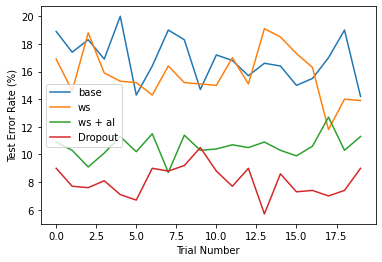

In [20]:
import matplotlib.pyplot as plt 
def mp(ls):
    return list(map(lambda x : x / 10,ls))
def plot_results(base, ws, ws_al, dropout):
    plt.plot(mp(base), label='base')
    plt.plot(mp(ws), label='ws')
    plt.plot(mp(ws_al), label='ws + al')
    plt.plot(mp(dropout), label='Dropout')
    plt.xlabel("Trial Number")
    plt.ylabel("Test Error Rate (%)")
    plt.legend()
    plt.savefig("benchmark_results.png")
    plt.show()
plot_results(results_base, results_ws, results_ws_al, results_dropout)

In [17]:
class Auxiliary_Loss_Net_Less_Parameters(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Layers that handle digit classification 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # Layers that handle comparisson 
        self.fc3 = nn.Linear(20, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 2)
        
    def cnn(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x
    
    def mlp(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
    def forward(self, x):
        s = x.shape
                
        input_1 = x[:,0,:,:].reshape([s[0],1,s[2],s[3]])
        input_2 = x[:,1,:,:].reshape([s[0],1,s[2],s[3]])

        
        output_1 = self.cnn(input_1)
        output_2 = self.cnn(input_2)
        concatenated = torch.cat((output_1, output_2), 1)
        
        comparison = self.mlp(concatenated)
        return output_1, output_2, comparison

In [18]:
def compute_nb_parameters(model, name = "Model"):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f'{name} has {pytorch_total_params} parameters. {pytorch_total_trainable_params} of them are trainable')
    
compute_nb_parameters(Base_Net(), "Baseline Model")
compute_nb_parameters(Weight_Sharing_Net(), "Weight Sharing Model")
compute_nb_parameters(Auxiliary_Loss_Weight_Sharing_Net(), "WS + AL Model")
compute_nb_parameters(Auxiliary_Loss_Net_Dropout(), "WS + AL + Dropout Model")
compute_nb_parameters(Auxiliary_Loss_Net_Less_Parameters(), "Reduced Param Model")

Baseline Model has 241654 parameters. 241654 of them are trainable
Weight Sharing Model has 169428 parameters. 169428 of them are trainable
WS + AL Model has 169428 parameters. 169428 of them are trainable
WS + AL + Dropout Model has 169428 parameters. 169428 of them are trainable
Reduced Param Model has 72460 parameters. 72460 of them are trainable


In [19]:
_ = benchmark_model(Auxiliary_Loss_Net_Less_Parameters, train_model_auxiliary_loss, compute_nb_errors_auxilary_loss, model_requires_target_and_classes=True)

test error Net trial 0 12.80% 128/1000
test error Net trial 1 13.40% 134/1000
test error Net trial 2 12.10% 121/1000
test error Net trial 3 12.90% 129/1000
test error Net trial 4 12.90% 129/1000
test error Net trial 5 11.20% 112/1000
test error Net trial 6 12.40% 124/1000
test error Net trial 7 10.70% 107/1000
test error Net trial 8 13.80% 138/1000
test error Net trial 9 12.30% 123/1000
test error Net trial 10 11.30% 113/1000
test error Net trial 11 13.40% 134/1000
test error Net trial 12 12.00% 120/1000
test error Net trial 13 13.30% 133/1000
test error Net trial 14 13.30% 133/1000
test error Net trial 15 11.90% 119/1000
test error Net trial 16 12.20% 122/1000
test error Net trial 17 10.50% 105/1000
test error Net trial 18 10.00% 100/1000
test error Net trial 19 12.40% 124/1000
Average precision of this architecture 12.24%
With standard deviation of  2.346912865872954
